# Gaussian Mixture BandPass Filter

For the mathematical details, please see

## Parameters for GMBPF

- `xiC`: the center angular frequency of passband.
- `sigma` : standard deviation of Gauss function. By this parameter, we can change passband width. 
- `shiftPixel` : The number of pixels of shift of center of the Gaussian function for ASFT (Attenuated Sliding Fourier Transform).
- `P` : The number of Fourier compoents to calcuate GMBPF
- `xiSL` : The list of center frequences of Gaussian functions in GMBPF. 

## Parameter of calculation
- `Ex` : In the calclation of Gaussian function by ASFT, interval $[-\mbox{K},\, \mbox{K}]$ is used to approximate it because of calculation time. However, to evaluate it, the ideal Gaussian function is approximated in interval $[-\mbox{KEx},\, \mbox{KEx}]$, where $\mbox{KEx}= \mbox{K}\times \mbox{Ex}$ 
- `passV` : the value of attenuation to calculate pass band wideth. (Now, it is set to -3 dB)
- `stopV` : the value of attenuation to calculate stop band wideth. (Now, it is set to -60 dB for P=16 and -100 dB for P=27)
- `KL` : the list of K to find K which provides the minimun error. (Now, the list has been checked for $P = 16,\,27$.

## Functions
- `gmbpfApprox()` : Calculate and evaluate the GMBPF with given parameter list, and return the best filter among the parameters.
- `gmbpfDesign()` : Set parameter list and call `gmbpfApprox()`, and return final paramters ofr GMPBF.

## Cells for calculation and output.

The five cells after functions, we prepare the following procedures.
- Calculate and output filter coefficients
- Calculate GMBPF
- Plot the output signal
- Plot the impluse responses of the filter and output them into a file. 
- Plot the DTFT of impluse response and calculate pass/stop band width.

## Execute the file

1. Make folder `Data` on your Desktop.
    - If you do not use Windows or change folter for data, please rewite `datafolder = os.environ['USERPROFILE'] + "/Desktop/Data/` in the next cell. 
1. Execute all cells.

In [30]:
# Set arameters 
import numpy as np
import os

xiC        = 0.4 * np.pi # The center angular frequency (rad)
sigma      = 250      # Standard deviation of Gauss function of time domain
shiftPixel = 20       # Shift for ASFT (pixel)
P          = 16       # Order of ASFT

xiSL       = np.pi * 0.6 * np.arange(-2, 3) / sigma # Gussian center angular frequency (0.6 is obtained hylistic.)

datafolder = os.environ['USERPROFILE'] + "/Desktop/Data/"

Ex         = 5                                      # Extension for error calculation
passV      = pow(10, -3/20) # -3 dB

# Set the scan interval of K and stop band attenuation
if P < 16:
    KL    = range(int(np.floor(2.6 * sigma)), int(np.floor(3.8 * sigma)) + 1)
    stopV = 1.0e-1                        # 10e-3 for 6dB  10e-5 for 100dB
elif P == 16:
    KL    = range(int(np.floor(3.6 * sigma)), int(np.floor(3.8 * sigma)) + 1)
    stopV = 1.0e-3                        # 10e-3 for 6dB  10e-5 for 100dB
elif P < 27:
    KL    = range(int(np.floor(3.6 * sigma)), int(np.floor(5.0 * sigma)) + 1)
    stopV = 1.0e-3                        # 10e-3 for 6dB  10e-5 for 100dB
elif P == 27:
    KL    = range(int(np.floor(4.8 * sigma)), int(np.floor(5.0 * sigma)) + 1)
    stopV = 1.0e-5                         # 10e-3 for 6dB  10e-5 for 100dB
else:
    print("Search by youself \n")
    exit



In [10]:
# Function to calc. fitters
import numpy as np

# sigma, KL, sPL, muL are necessary as well as P, xiC, heightFilter
def gmbpfApprox(scan, sigma, KL, sPB, nsPL, muL, P, xiC, heightFilter):
    
    nKL  = len(KL)
    nmuL = muL.shape[0]
    
    if scan == 1:
        resultTbl  = np.zeros((16, nKL * nsPL * nmuL))
    else:
        resultTbl  = np.zeros((16, 1))

    pos = 0
    for K in KL:
        KEx     = Ex * K
        piByK   = np.pi / K
        w       = sigma * piByK
        sPC     = int(xiC / piByK)
        N       = 2 * K + 1
        NEx     = 2 * KEx + 1
        posL    = range(K * (Ex - 1) + 1, K * (Ex + 1) + 1 + 1)
        posExtL = np.append(range(0, K * (Ex - 1)),  range(K * (Ex + 1) + 1, NEx))  # Position for extension

        thetaL   = piByK * np.arange(-K, K + 1)
        thetaExL = piByK * np.arange(-KEx, KEx + 1)

        beta        = 1.0 / (2.0 * w * w)
        betaw       = 2.0 * beta
        shiftTheta  = piByK * shiftPixel
        alphaPixel  = shiftPixel / (sigma * sigma)
        thetaExSftL = thetaExL + shiftTheta

        xiL = xiSL + xiC
        filterExL  = np.zeros((NEx))
        
        for xi in xiL:
            xiP       = xi / piByK
            filterExL = filterExL + np.exp(- beta * (thetaExSftL * thetaExSftL) ) * np.cos(xiP * thetaExSftL)

        filterExL    = filterExL / heightFilter
        sqFilter     = np.dot(filterExL, filterExL)       # Norm of extended fiter
        filterL      = filterExL[posL]                    # Inter [-K, K] data
        filterExtL   = filterExL[posExtL]                 # Outer [-K, K] data
        trErrFilter  = np.dot(filterExtL, filterExtL)     # Trancation Error

        if scan == 1:
            sPL  = range(int(sPC - P // 2 - (nsPL - 1) // 2 + sPB), int(sPC - P // 2 + (nsPL - 1) // 2 + sPB + 1))
        else:
            sPL = [sPB]

        for PN in range(0, nsPL):
            sP     = sPL[PN]
            eP     = sP + P - 1

# Calc. ASFT
            coefExp  = np.exp(- alphaPixel * np.arange(0, N))
            cosExpLL = np.zeros((eP - sP + 1, N))
            sinExpLL = np.zeros((eP - sP + 1, N))
            for p in range(sP, eP + 1):
                cosExpLL[p - sP, :] = np.cos(p * thetaL) * coefExp
                sinExpLL[p - sP, :] = np.sin(p * thetaL) * coefExp

            if shiftPixel != 0: # ASFT
                triExpLL = np.concatenate((cosExpLL, sinExpLL), axis = 0)
            else: # SFT
                triExpLL = cosExpLL
    
            for mu in muL:
                edgeCond   =  triExpLL[:, [0, N-1]]   # Edge height at 1 and 2K + 1     
                coefFilter = np.dot(np.linalg.inv(np.dot(triExpLL, triExpLL.T) + mu * (np.dot(edgeCond, edgeCond.T) )), np.dot(triExpLL, filterL)) # Calc. filter coefficent
                filterAL    = np.dot(np.transpose(coefFilter), triExpLL)                       # Approximated data
                apErrFilter = np.dot(filterAL - filterL, filterAL - filterL) #Order error
                numerS      = 0.5 * (abs(filterAL[0]) + abs(filterAL[N - 1]))   # Leap at edge point

                resultTbl[0, pos]  = K
                resultTbl[1, pos]  = shiftPixel
                resultTbl[2, pos]  = sP
                resultTbl[3, pos]  = eP
                resultTbl[4, pos]  = xiC
                resultTbl[5, pos]  = sigma
                resultTbl[6, pos]  = mu
                resultTbl[7, pos]  = 100 * np.sqrt(trErrFilter / sqFilter)
                resultTbl[8, pos]  = 100 * np.sqrt(apErrFilter  / sqFilter) 
                resultTbl[9, pos] = 100 * np.sqrt((trErrFilter + apErrFilter) / sqFilter)
                resultTbl[10, pos] = np.abs( filterAL[N - 1] / (filterL[N - 1] - filterL[N - 2]) ) 
                # resultTbl(12, pos) = numer / abs(mtSftL(2) - mtSftL(1))
                # resultTbl(13, pos) = numer / abs(mtSftA(2) - mtSftA(1))
                # resultTbl(14, pos) = invType

                pResult = resultTbl[:, pos]
                #print("%9.6f  %1d %5d  %7d %4d %6d %4d %6.2e  %6.2e %6.2e\n " % \
                #      (pResult[4], 3, pResult[5], pResult[0], pResult[1], pResult[2], pResult[3] - pResult[2] + 1, pResult[6], pResult[9], pResult[10]))
                pos = pos + 1
    wlst   = np.where(resultTbl[10, :] < 1.2)[0]
    if len(wlst) != 0:
        extResTbl = resultTbl[:,wlst]
        minInd    = np.argmin(extResTbl[9])
        retTbl    = np.array(extResTbl[:, minInd])
    else:
        retTbl = np.array([])
    return retTbl, len(wlst), coefFilter, filterL, filterAL, filterExL


In [20]:
# Function to design GMBPF
import numpy as np

def gmbpfDesign(xiC, xiSL, P, sigma, KL):
    scan = 1  # scan 
    nsPL = 11 # Num of sp scan
    sPB  = 0  # sP scan bias from center frequency or sP (if scan == 0)

    # Scan mu
    quadL  = np.array([1.0, np.sqrt(np.sqrt(10.0)), np.sqrt(10.0), np.sqrt(10.0 * np.sqrt(10.0))])
    muBase = 1.0
    muL    = np.append(np.array([0.0]), muBase * quadL)

    fNameE = datafolder + "errorList_%5.3f_%.0f_Sft%d_P%02d.txt" % (xiC / np.pi, sigma, shiftPixel, P)
    with open(fNameE,  encoding="utf-8", mode='a') as fp:
        fp.write("# xiC   sigma      totErr(percent) \%  K    shift   sP   eP  mu  edgeErr \n")

    # Org filter
    xiL         = xiSL + xiC
    KOrg        = int(np.floor(6  * sigma)) # Long length is used for original filter.
    NOrg        = 2 * KOrg + 1
    filterOrgL  = np.zeros((NOrg))
    betaOrg     = 1.0 / (2.0 * sigma * sigma)
    nL          = np.arange(-KOrg, KOrg + 1)

    # Used only for calculate the height Filter
    for xi in xiL:
        filterOrgL = filterOrgL + np.exp(- betaOrg * (nL * nL)) * (np.cos((xi) * nL))

    heightFilter = np.dot(filterOrgL,  np.cos(xiC * nL))

    while True:
        minResult, nWlst, coefFilter, filterL, filterAL, filterExL = gmbpfApprox(scan, sigma, KL, sPB, nsPL, muL, P, xiC, heightFilter)
        #print('KL[0] = ' KL[0], ', KL[last] = ', KL[len(KL) - 1], ', sPB = ', sPB, ', mu = ', muL[0], ', nWlst =', nWlst)
        if nWlst >= 1:
            K   = int(minResult[0])
            sP  = int(minResult[2])
            mu = minResult[6]
            # print('K = ', K, ', sP = ', sP, ', mu =  ', mu)
            if (K > KL[1]) and (K < KL[len(KL) - 2]): # K is OK
                sPS   = int(np.floor(xiC * K / np.pi - P // 2)) + sPB
                nsPLH = (nsPL - 1) / 2  # H means half
                if (sP <= sPS - nsPLH + 1):
                    sPB = sPB - nsPLH
                elif (sP >= sPS + nsPLH - 1): 
                    sPB = sPB + nsPLH
                else:  # sP is OK
                    break
            else:
                KL = range(K - 10, K + 10 + 1)
        else:
            muBase = muBase * 10.0
            muL    = np.array(muBase * quadL)

    str0 = "Min: %9.6f  %1d %5d  %7d %4d %6d %4d %6.2e  %6.2e %6.2e\n" % \
           (minResult[4], 3, minResult[5], minResult[0], minResult[1], minResult[2], minResult[3] - minResult[2] + 1, minResult[6], minResult[9], minResult[10])
    print(str0)
    with open(fNameE,  encoding="utf-8", mode="a") as fp:
        fp.write(str0)

    # Reculculate minimum filter
    scan = 0   # Not scan
    KL   = [K]
    sPB  = sP
    muL  = np.array([mu])
    nsPL = 1
    minResult, nWlst, coefFilter, filterL, filterAL, filterExL = gmbpfApprox(scan, sigma, KL, sPB, nsPL, muL, P, xiC, heightFilter)

    # Coefficients of ASFT filter
    if sP % 2 == 0:
        sSg = 1
    else:
        sSg = -1
    sg = sSg

    coefFilterCSg = np.zeros((P))
    coefFilterSSg = np.zeros((P))
    if shiftPixel != 0: # ASFT
        coefFilterSg = np.zeros((2 * P))
        for posC in range(0, P):
            coefFilterCSg[posC] =   sg * coefFilter[posC]
            coefFilterSSg[posC] = - sg * coefFilter[posC + P]
            sg = -sg
    else: # SFT
        coefFilterSg = np.zeros((P));
        for posC in range(0, P):
            coefFilterCSg[posC]     =   sg * coefFilter[posC]
            sg = -sg

    # Save data necessary for fiter
    thetaPL     = np.arange(sP, sP + P) * (np.pi / K)
    alphaPixel  = shiftPixel / (sigma * sigma)
    cosPara = np.cos(thetaPL) * np.exp(- alphaPixel)
    sinPara = np.sin(thetaPL) * np.exp(- alphaPixel)
    subPara = np.exp(- 2 * K * alphaPixel)
   
    return K, subPara, cosPara, sinPara, coefFilterCSg, coefFilterSSg, filterL, filterAL, filterExL, minResult


In [23]:
# Calculate and output filter coefficients
K, subPara, cosPara, sinPara, coefFilterCSg, coefFilterSSg, filterL, filterAL, filterExL, minResult = \
gmbpfDesign(xiC, xiSL, P, sigma, KL)

# Output Coefficients of ASFT filter
fName = datafolder + "coef_%5.3f_%.0f_Sft%d_P%02d.txt" % (xiC / np.pi, sigma, shiftPixel, P)
print("Files are in" + datafolder)
with open(fName,  encoding="utf-8", mode="w") as fp:
    if shiftPixel != 0: # ASFT
        for posC in range(0, P):
            str0 = "%e\n" % (coefFilterCSg[posC])
            fp.write(str0)
        for posC in range(0, P):
            str0 = "%e\n" % (coefFilterSSg[posC])
            fp.write(str0)
    else:  # SFT
        for posC in range(0, P):
            str0 = "%e\n" % (coefFilterCg[posC])
            fp.write(str0)


Min:  1.256637  3   250      911   20    357   16 0.00e+00  9.75e-02 7.70e-01

Files are inC:\Users\vax73/Desktop/Data/


In [24]:
# Calculate GMBPF
import numpy as np

# K, subPara, cosPara, sinPara, coefFilterCSg, coefFilterSSg, filterL, filterAL, filterExL, minResult = gmbpfDesign(xiC, xiSL, P, sigma, KL)

# Input signal for test
#inSig        = np.zeros((10000))
#inSig[5000] = 1
inSig        = np.cos((xiC + 0.00 * np.pi) * np.arange(0, 100000))

# Allocate memory for output
K2     = K + K
L      = len(inSig)
outSig = np.zeros((L + K2))
if L < K2:
    inSig = np.append(inSig, np.zeros((K2 - L)))
    L = K2

# Apply Filter
inteCos    = np.zeros((P))
inteSin    = np.zeros((P))
inteCosTmp = np.zeros((P))

if shiftPixel != 0: # ASFT
    for pos in range(0, K2):
        add  = inSig[pos]
        inteCosTmp = inteCos
        inteCos = cosPara * inteCosTmp - sinPara * inteSin + add
        inteSin = sinPara * inteCosTmp + cosPara * inteSin
        outSig[pos] = np.sum(coefFilterCSg * inteCos) + np.sum(coefFilterSSg * inteSin) 


    for pos in range(K2, L):
        add = inSig[pos]
        sub = subPara * inSig[pos - K2]

        inteCosTmp = inteCos
        inteCos = cosPara * inteCosTmp - sinPara * inteSin + add
        inteSin = sinPara * inteCosTmp + cosPara * inteSin
        outSig[pos] = np.sum(coefFilterCSg * inteCos) + np.sum(coefFilterSSg * inteSin) 
        inteCos = inteCos - sub


    for pos in range(L, L + K2):
        sub = subPara * inSig[pos - K2]

        inteCosTmp = inteCos
        inteCos = cosPara * inteCosTmp - sinPara * inteSin
        inteSin = sinPara * inteCosTmp + cosPara * inteSin
        outSig[pos] = np.sum(coefFilterCSg * inteCos) + np.sum(coefFilterSSg * inteSin) 
        inteCos = inteCos - sub  
else:
    for pos in range(0, K2):
        add  = inSig[pos]

        inteCosTmp = inteCos
        inteCos = cosPara * inteCosTmp - sinPara * inteSin + add
        inteSin = sinPara * inteCosTmp + cosPara * inteSin
        outSig[pos] = np.sum(coefFilterCSg * inteCos)

    for pos in range(K2, L):
        add = inSig[pos]
        sub = subPara * inSig[pos - K2]

        inteCosTmp = inteCos
        inteCos = cosPara * inteCosTmp - sinPara * inteSin + add
        inteSin = sinPara * inteCosTmp + cosPara * inteSin
        outSig[pos] = np.sum(coefFilterCSg * inteCos)
        inteCos = inteCos - sub

    for pos in range(L, L + K2):
        sub = subPara * inSig[pos - K2]

        inteCosTmp = inteCos
        inteCos = cosPara * inteCosTmp - sinPara * inteSin
        inteSin = sinPara * inteCosTmp + cosPara * inteSin
        outSig[pos] = np.sum(coefFilterCSg * inteCos)
        inteCos = inteCos - sub


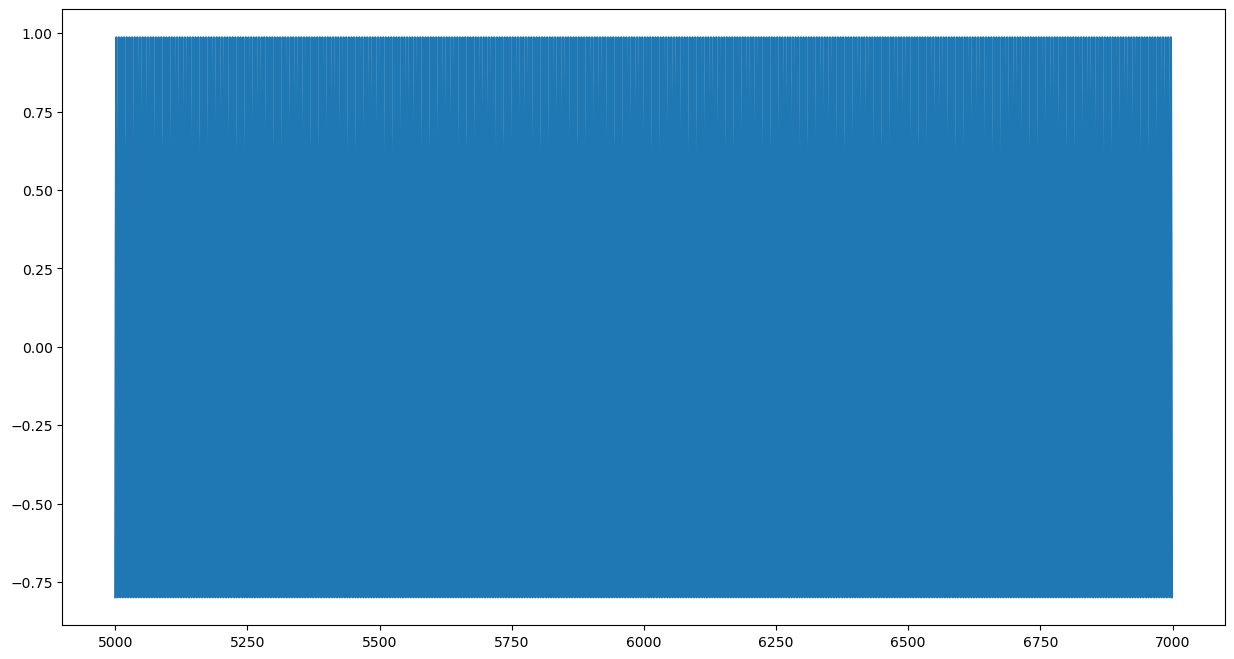

In [25]:
# Plot the output signal
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
#plt.plot(range(0, len(inSig)), inSig)
extrInt = range(5000, 7000)
plt.plot(extrInt, outSig[extrInt])
plt.show()

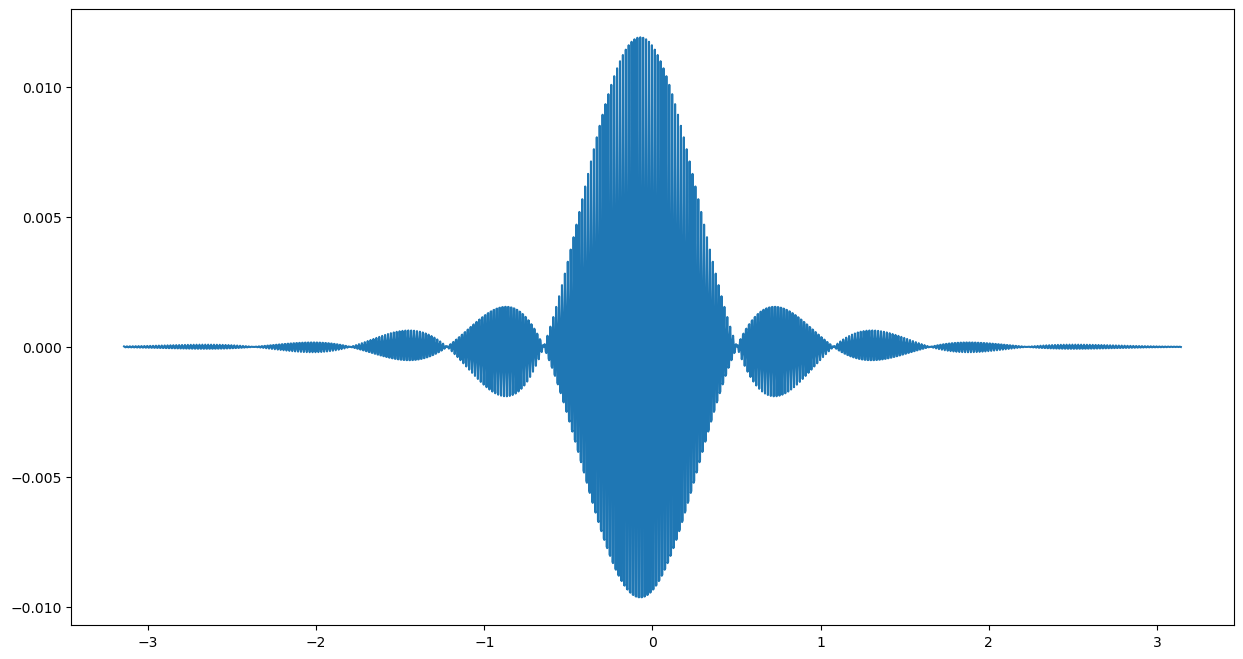

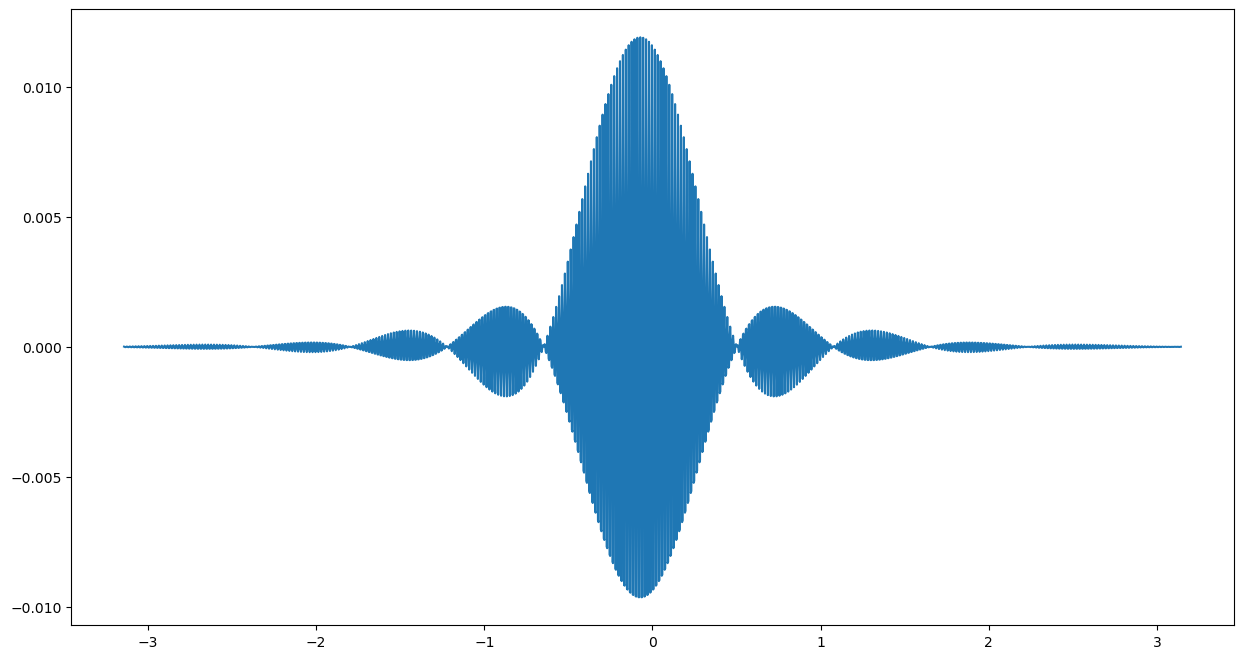

In [27]:
# Plot the impluse responses of the filter and output them into a file.                                                                                                                                                                                                                                                                                                                                                                                                                        

import numpy as np
import matplotlib.pyplot as plt

piByK    = np.pi / K
thetaL   = piByK * np.arange(-K, K + 1)
thetaExL = piByK * np.arange(-K * Ex, K * Ex + 1)

plt.figure(figsize=(15,8))
plt.plot(thetaL, filterL)
plt.show()
plt.figure(figsize=(15,8))
plt.plot(thetaL, filterAL)
plt.show()

fName = datafolder + "filter_%5.3f_%.0f_Sft%d_P%02d.txt" % (xiC / np.pi, sigma, shiftPixel, P)
pos = -K
stepA = 0.0 # for step response
stepO = 0.0

with open(fName,  encoding="utf-8", mode="w") as fp:
    for posE in range(K * (Ex - 2), K * (Ex - 1) ):
        stepO = stepO + filterExL[posE]
        str0 = "%e %d %d %e %e %e %e \n" % (thetaExL[posE], posE - K * Ex - 1, pos,  0.0, filterExL[posE], stepA, stepO)
        fp.write(str0)
        pos = pos + 1

    for posE in range(K * (Ex - 1), K * (Ex + 1) + 1):
        stepA = stepA + filterAL[pos]
        stepO = stepO + filterExL[posE]
        str0 = "%e %d %d %e %e %e %e \n" % (thetaExL[posE], posE - K * Ex - 1, pos, filterAL[pos], filterExL[posE], stepA, stepO)
        fp.write(str0)
        pos = pos + 1

    for posE in range(K * (Ex + 1) + 1, K * (Ex + 2)):
        stepO = stepO + filterExL[posE]
        str0 = "%e %d %d %e %e %e %e \n" % (thetaExL[posE], posE - K * Ex - 1, pos, 0.0, filterExL[posE], stepA, stepO)
        fp.write(str0)
        pos = pos + 1

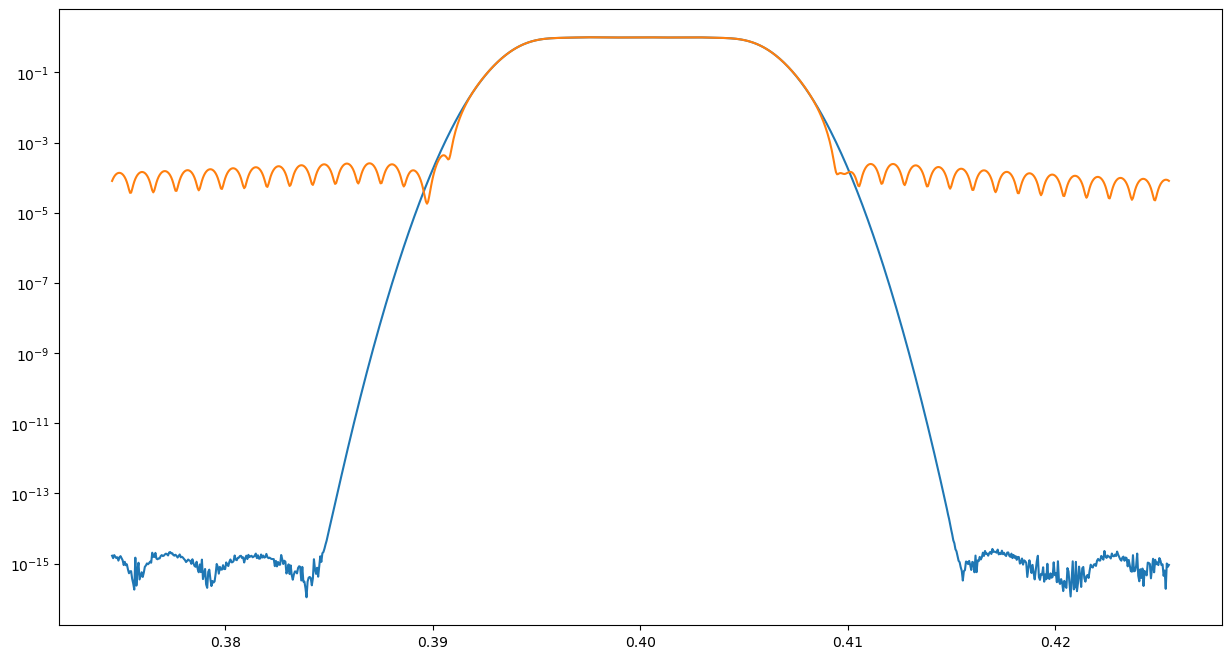

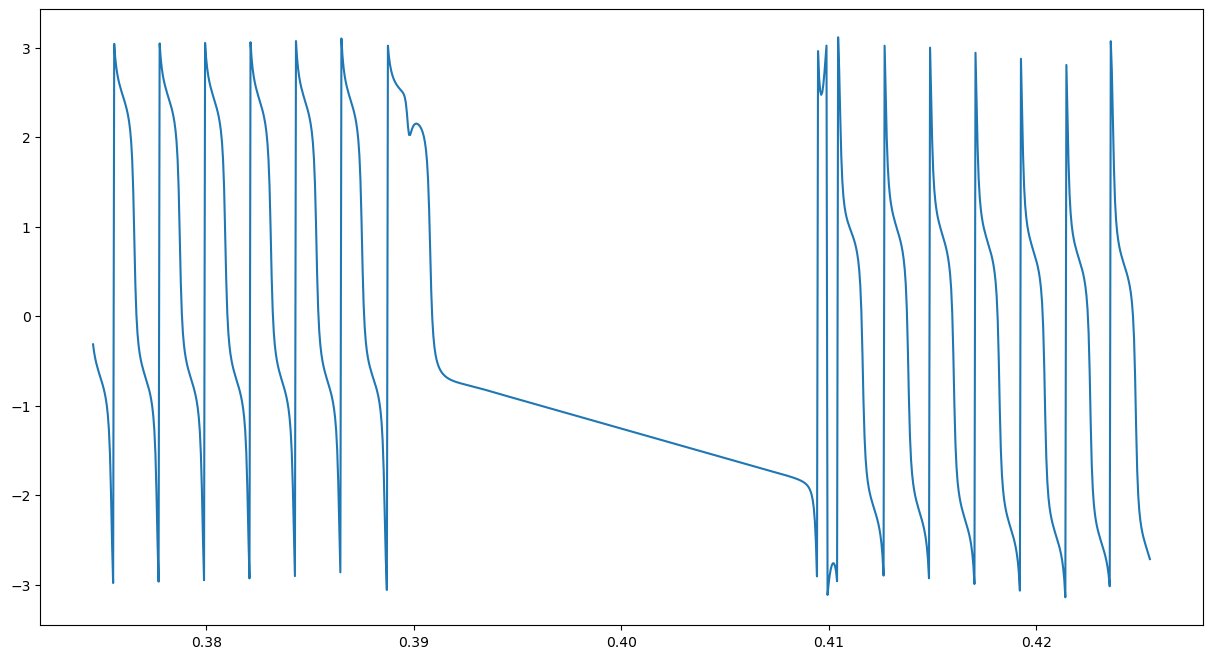

# sigma = 250.000000 xiC = 1.256637 K = 911 sP = 357 P = 16 shift = 20 toterror = 0.770112

# Pass band width ( -3dB) = 0.010848 pi, Stop band width (-60dB) = 0.018182 pi  3.9460239970e-01 pi  4.0545040063e-01 pi  3.9098639940e-01 pi  4.0916826010e-01 pi



In [28]:
# Plot the DTFT of impluse response and calculate pass/stop band width.

import numpy as np
import matplotlib.pyplot as plt

KEx          = Ex * K
dtftT         = np.zeros((1, 2 * KEx + 1))
dtftT[0, :]   = np.arange(-KEx, KEx + 1)

dtftTA        = np.zeros((1, 2 * K + 1))
dtftTA[0, :]  = np.arange(-K, K + 1)


# deltaOmega     = 1.0/sigma # For plot all
deltaOmega       = 0.04/sigma
dtftOmegaL       = np.arange(0, np.pi, deltaOmega)
nDtftOmega       = len(dtftOmegaL)
dtftOmegaM       = np.zeros((1, nDtftOmega))
dtftOmegaM[0, :] = dtftOmegaL

nDC           = int((nDtftOmega - 1) * xiC / np.pi ) + 1
nDL           = range(nDC -500, nDC + 500 + 1)
dtftDOmegaM   = dtftOmegaM[:, nDL] # For extracted passBand part

dtftC         = np.dot(filterExL, np.cos(np.dot(dtftT.T, dtftDOmegaM)))
dtftS         = np.dot(filterExL, np.sin(np.dot(dtftT.T, dtftDOmegaM)))
dtft          = np.sqrt(dtftC * dtftC + dtftS * dtftS)

dtftCA         = np.dot(filterAL, np.cos(np.dot(dtftTA.T, dtftDOmegaM)))
dtftSA         = np.dot(filterAL, np.sin(np.dot(dtftTA.T, dtftDOmegaM)))
dtftA          = np.sqrt(dtftCA * dtftCA + dtftSA * dtftSA)
angleLA        = np.arctan2(dtftSA, dtftCA)

plt.figure(figsize=(15,8))
plt.semilogy(dtftDOmegaM[0, :] / np.pi, dtft)
plt.semilogy(dtftDOmegaM[0, :] / np.pi, dtftA)
plt.show()

plt.figure(figsize=(15,8))
plt.plot(dtftDOmegaM[0,:] / np.pi, angleLA)
plt.show()

### Calc. bandwidth
dtftOmegaBWL  = np.arange(0, np.pi, deltaOmega)
nDtftOmegaBW  = len(dtftOmegaBWL)
nCBW          = int( (nDtftOmegaBW - 1) * xiC / np.pi ) + 1
nBWL          = range(-500 + nCBW, 501 + nCBW)
dtftOmegaBWSM       = np.zeros((1, 1001))
dtftOmegaBWSM[0, :] = dtftOmegaBWL[nBWL]
dtftBWSCA     = np.dot(filterAL, np.cos(np.dot(dtftTA.T, dtftOmegaBWSM)))
dtftBWSSA     = np.dot(filterAL, np.sin(np.dot(dtftTA.T, dtftOmegaBWSM)))
dtftBWSA      = np.sqrt(dtftBWSCA * dtftBWSCA + dtftBWSSA * dtftBWSSA)
dtftBWSA      = dtftBWSA / np.max(dtftBWSA)
for pos in range(1, len(nBWL)):
    if (dtftBWSA[pos - 1] < passV) and (dtftBWSA[pos] >= passV): 
        pbwL = dtftOmegaBWSM[0, pos]
    if (dtftBWSA[pos - 1] > passV) and (dtftBWSA[pos] <= passV):
        pbwH = dtftOmegaBWSM[0, pos]
    if (dtftBWSA[pos - 1] < stopV) and (dtftBWSA[pos] >= stopV):
        sbwL = dtftOmegaBWSM[0, pos]
    if (dtftBWSA[pos - 1] > stopV) and (dtftBWSA[pos] <= stopV):
        sbwH = dtftOmegaBWSM[0, pos]

# print fiter and passband
strFilter = "# sigma = %f xiC = %f K = %d sP = %d P = %d shift = %d toterror = %f\n" % (minResult[5], minResult[4], minResult[0], minResult[2], P, minResult[1], minResult[10])
strBand   = "# Pass band width (%3.0fdB) = %f pi, Stop band width (%3.0fdB) = %f pi  %15.10e pi  %15.10e pi  %15.10e pi  %15.10e pi\n" % (20 * np.log10(passV), (pbwH - pbwL) / np.pi, 20 * np.log10(stopV), (sbwH - sbwL) / np.pi, pbwL/np.pi, pbwH/np.pi, sbwL/np.pi, sbwH/np.pi)

print(strFilter)
print(strBand)


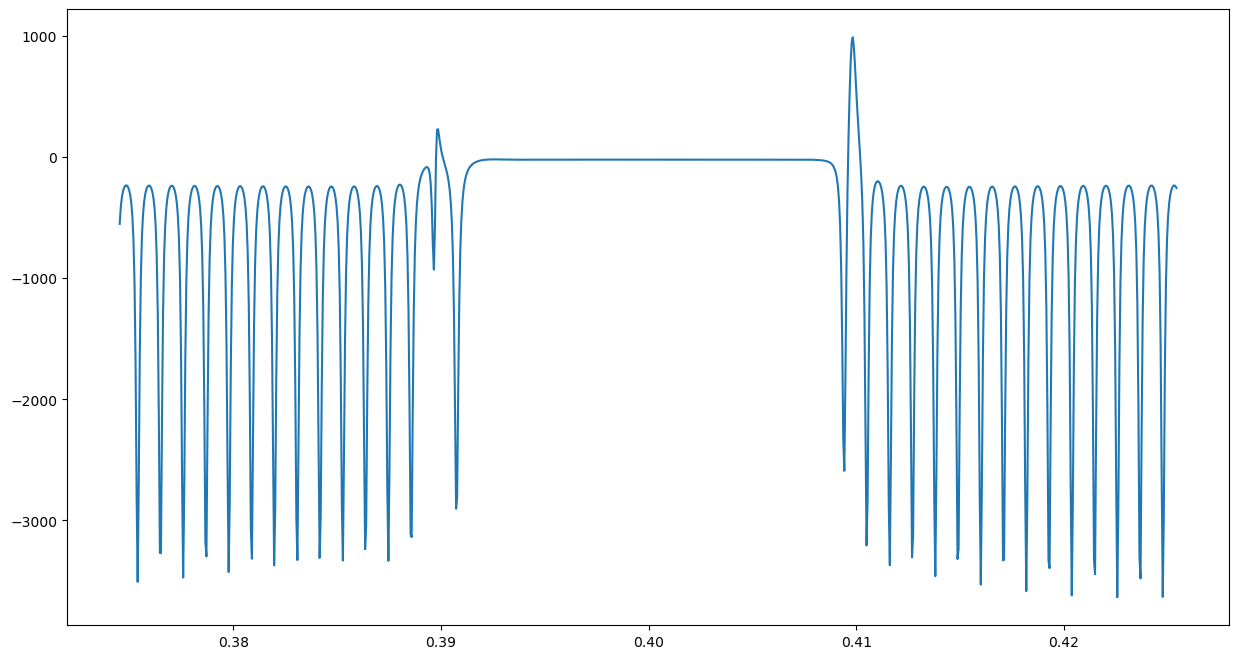

C:\Users\vax73/Desktop/Data/dtft_0.400_250_Sft20_P16.txt


In [29]:
# Output the delay of the filter

dtftCADelay   = np.dot(filterAL, np.cos(np.dot(dtftTA.T, dtftDOmegaM)))
dtftSADelay   = np.dot(filterAL, np.sin(np.dot(dtftTA.T, dtftDOmegaM)))

angleLADelay = np.arctan2(dtftSADelay, dtftCADelay)

gDelay = angleLADelay[range(1, 1001)] - angleLADelay[range(0, 1000)]
gDelay = np.where(gDelay <=  np.pi, gDelay, gDelay - 2 * np.pi)
gDelay = np.where(gDelay >  -np.pi, gDelay, gDelay + 2 * np.pi) / deltaOmega

plt.figure(figsize=(15,8))
plt.plot(dtftDOmegaM[0,range(0, 1000)] / np.pi, gDelay)
plt.show()

fName = datafolder + "dtft_%5.3f_%.0f_Sft%d_P%02d.txt" % (xiC / np.pi, sigma, shiftPixel, P)
print(fName)
with open(fName,  encoding="utf-8", mode="w") as fp:
    for pos in range(0, dtftDOmegaM.shape[1] - 1):
        str0 = "%e %e %e  %f  %e %e \n" % (dtftDOmegaM[0, pos] / np.pi, 20 * np.log10(abs(dtftC[pos])), 20 * np.log10(abs(dtftCA[pos])), angleLA[pos], (dtftDOmegaM[0, pos + 1] + dtftDOmegaM[0, pos] )/ (2 * np.pi), gDelay[pos] )
        fp.write(str0)
    fp.write(strFilter)
    fp.write(strBand)
